In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, gcf

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from keras.models import Model, Sequential
import random as python_random
import tensorflow as tf
import seaborn as sns;sns.set_theme(color_codes=True)
import random


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
random.seed(18)
print(random.random())

0.18126486333322134


In [4]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
dfs = load_train_test_data(data_directory, train_or_test = "all")
train_init = dfs[0]
test_init = dfs[1]
gene_stats = dfs[2]

In [5]:
# drop the string values
train_df = train_init.drop(columns= ["DepMap_ID", "age_and_sex"])
test_df = test_init.drop(columns= ["DepMap_ID", "age_and_sex"])

In [6]:
# subsetting the genes 
# create dataframe containing the 1000 genes with the largest variances and their corresponding gene label and extract the gene labels
largest_var_df = gene_stats.nlargest(1000, "variance")
gene_list = largest_var_df["gene_ID"].tolist()
gene_list

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list, axis = 1)
subset_test_df = test_df.filter(gene_list, axis = 1)

In [7]:
print(subset_train_df.shape)
subset_train_df.head(3)

(751, 1000)


,GPX4 (2879),ITGAV (3685),CDK6 (1021),SCAP (22937),CCND1 (595),FERMT2 (10979),TYMS (7298),PCYT1A (5130),SDHB (6390),CFLAR (8837),...,TCERG1 (10915),MRPL49 (740),URM1 (81605),BRAP (8315),CCDC144A (9720),EXOC2 (55770),TCOF1 (6949),UBE3D (90025),PARN (5073),GSDMA (284110)
0,0.011581,0.770145,0.932997,0.054943,0.999962,0.909631,0.094852,0.117865,0.427640,0.190956,...,0.616313,0.244505,0.769569,0.291900,0.558567,0.760100,0.932975,0.031527,0.277917,0.314233
1,0.053997,0.009904,0.367195,0.001506,0.994464,0.015096,0.880810,0.905601,0.949642,0.726629,...,0.272177,0.154228,0.898438,0.388043,0.673615,0.199419,0.985815,0.160459,0.818588,0.829236
2,0.134245,0.055602,0.024801,0.317717,0.085127,0.269408,0.987037,0.014647,0.847858,0.106740,...,0.121123,0.871377,0.721131,0.229842,0.194259,0.092700,0.844732,0.124325,0.340351,0.344487


In [8]:
print(subset_test_df.shape)
subset_test_df.head(3)

(133, 1000)


,GPX4 (2879),ITGAV (3685),CDK6 (1021),SCAP (22937),CCND1 (595),FERMT2 (10979),TYMS (7298),PCYT1A (5130),SDHB (6390),CFLAR (8837),...,TCERG1 (10915),MRPL49 (740),URM1 (81605),BRAP (8315),CCDC144A (9720),EXOC2 (55770),TCOF1 (6949),UBE3D (90025),PARN (5073),GSDMA (284110)
0,0.099350,0.849009,0.023172,0.599967,0.087205,0.135586,0.995883,0.948425,0.892461,0.648334,...,0.843236,0.876208,0.758239,0.377978,0.648197,0.678042,0.977397,0.035103,0.389403,0.207370
1,0.821185,0.052062,0.208097,0.928353,0.978505,0.249416,0.016701,0.371935,0.857939,0.864571,...,0.776906,0.813475,0.934780,0.245852,0.625234,0.042365,0.812659,0.113039,0.415324,0.681331
2,0.970077,0.183512,0.909020,0.970670,0.126900,0.148982,0.969827,0.929632,0.893441,0.094053,...,0.539989,0.961715,0.870768,0.101138,0.502977,0.136978,0.961490,0.020495,0.230682,0.366392


In [9]:
encoder_architecture = []
decoder_architecture = []

In [10]:
# These optimal parameter values were fetched by running "optimize_hyperparameters.py" and then running "fetch_hyper_params.ipynb"
cp_vae = VAE(
    input_dim=subset_train_df.shape[1],
    latent_dim=10,
    batch_size=16,
    encoder_batch_norm=False,
    epochs=40,
    learning_rate=0.005,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1.6,
    lam=0,
    verbose=True,
)

cp_vae.compile_vae()

2022-08-10 10:43:29.259644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-10 10:43:29.735498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:41:00.0, compute capability: 8.6
/home/markw/miniconda3/envs/test01/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
cp_vae.train(x_train = subset_train_df, x_test = subset_test_df)

Epoch 1/40
47/47 [==============================] - ETA: 0s - loss: 141.4873 - recon: 123.4004 - kl: 18.0869

2022-08-10 10:43:31.464539: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


47/47 [==============================] - 2s 7ms/step - loss: 141.4873 - recon: 123.4004 - kl: 18.0869 - val_loss: 92.1899 - val_recon: 80.7053 - val_kl: 11.4846
Epoch 2/40
47/47 [==============================] - 0s 4ms/step - loss: 87.8350 - recon: 75.3367 - kl: 12.4983 - val_loss: 87.2872 - val_recon: 74.4518 - val_kl: 12.8354
Epoch 3/40
47/47 [==============================] - 0s 4ms/step - loss: 83.2212 - recon: 70.3034 - kl: 12.9178 - val_loss: 85.5744 - val_recon: 74.9803 - val_kl: 10.5941
Epoch 4/40
47/47 [==============================] - 0s 4ms/step - loss: 82.3869 - recon: 68.9027 - kl: 13.4841 - val_loss: 81.8272 - val_recon: 68.2065 - val_kl: 13.6207
Epoch 5/40
47/47 [==============================] - 0s 4ms/step - loss: 80.4871 - recon: 67.2078 - kl: 13.2793 - val_loss: 81.7417 - val_recon: 67.8149 - val_kl: 13.9268
Epoch 6/40
47/47 [==============================] - 0s 4ms/step - loss: 78.5627 - recon: 65.8039 - kl: 12.7588 - val_loss: 81.2898 - val_recon: 68.5160 - val_k

In [12]:
# display training history
history_df = pd.DataFrame(cp_vae.vae.history.history)

# save the training history as a .csv
hist_dir = pathlib.Path("./results/beta_vae_training_history.csv")
history_df.to_csv(hist_dir, index = False)

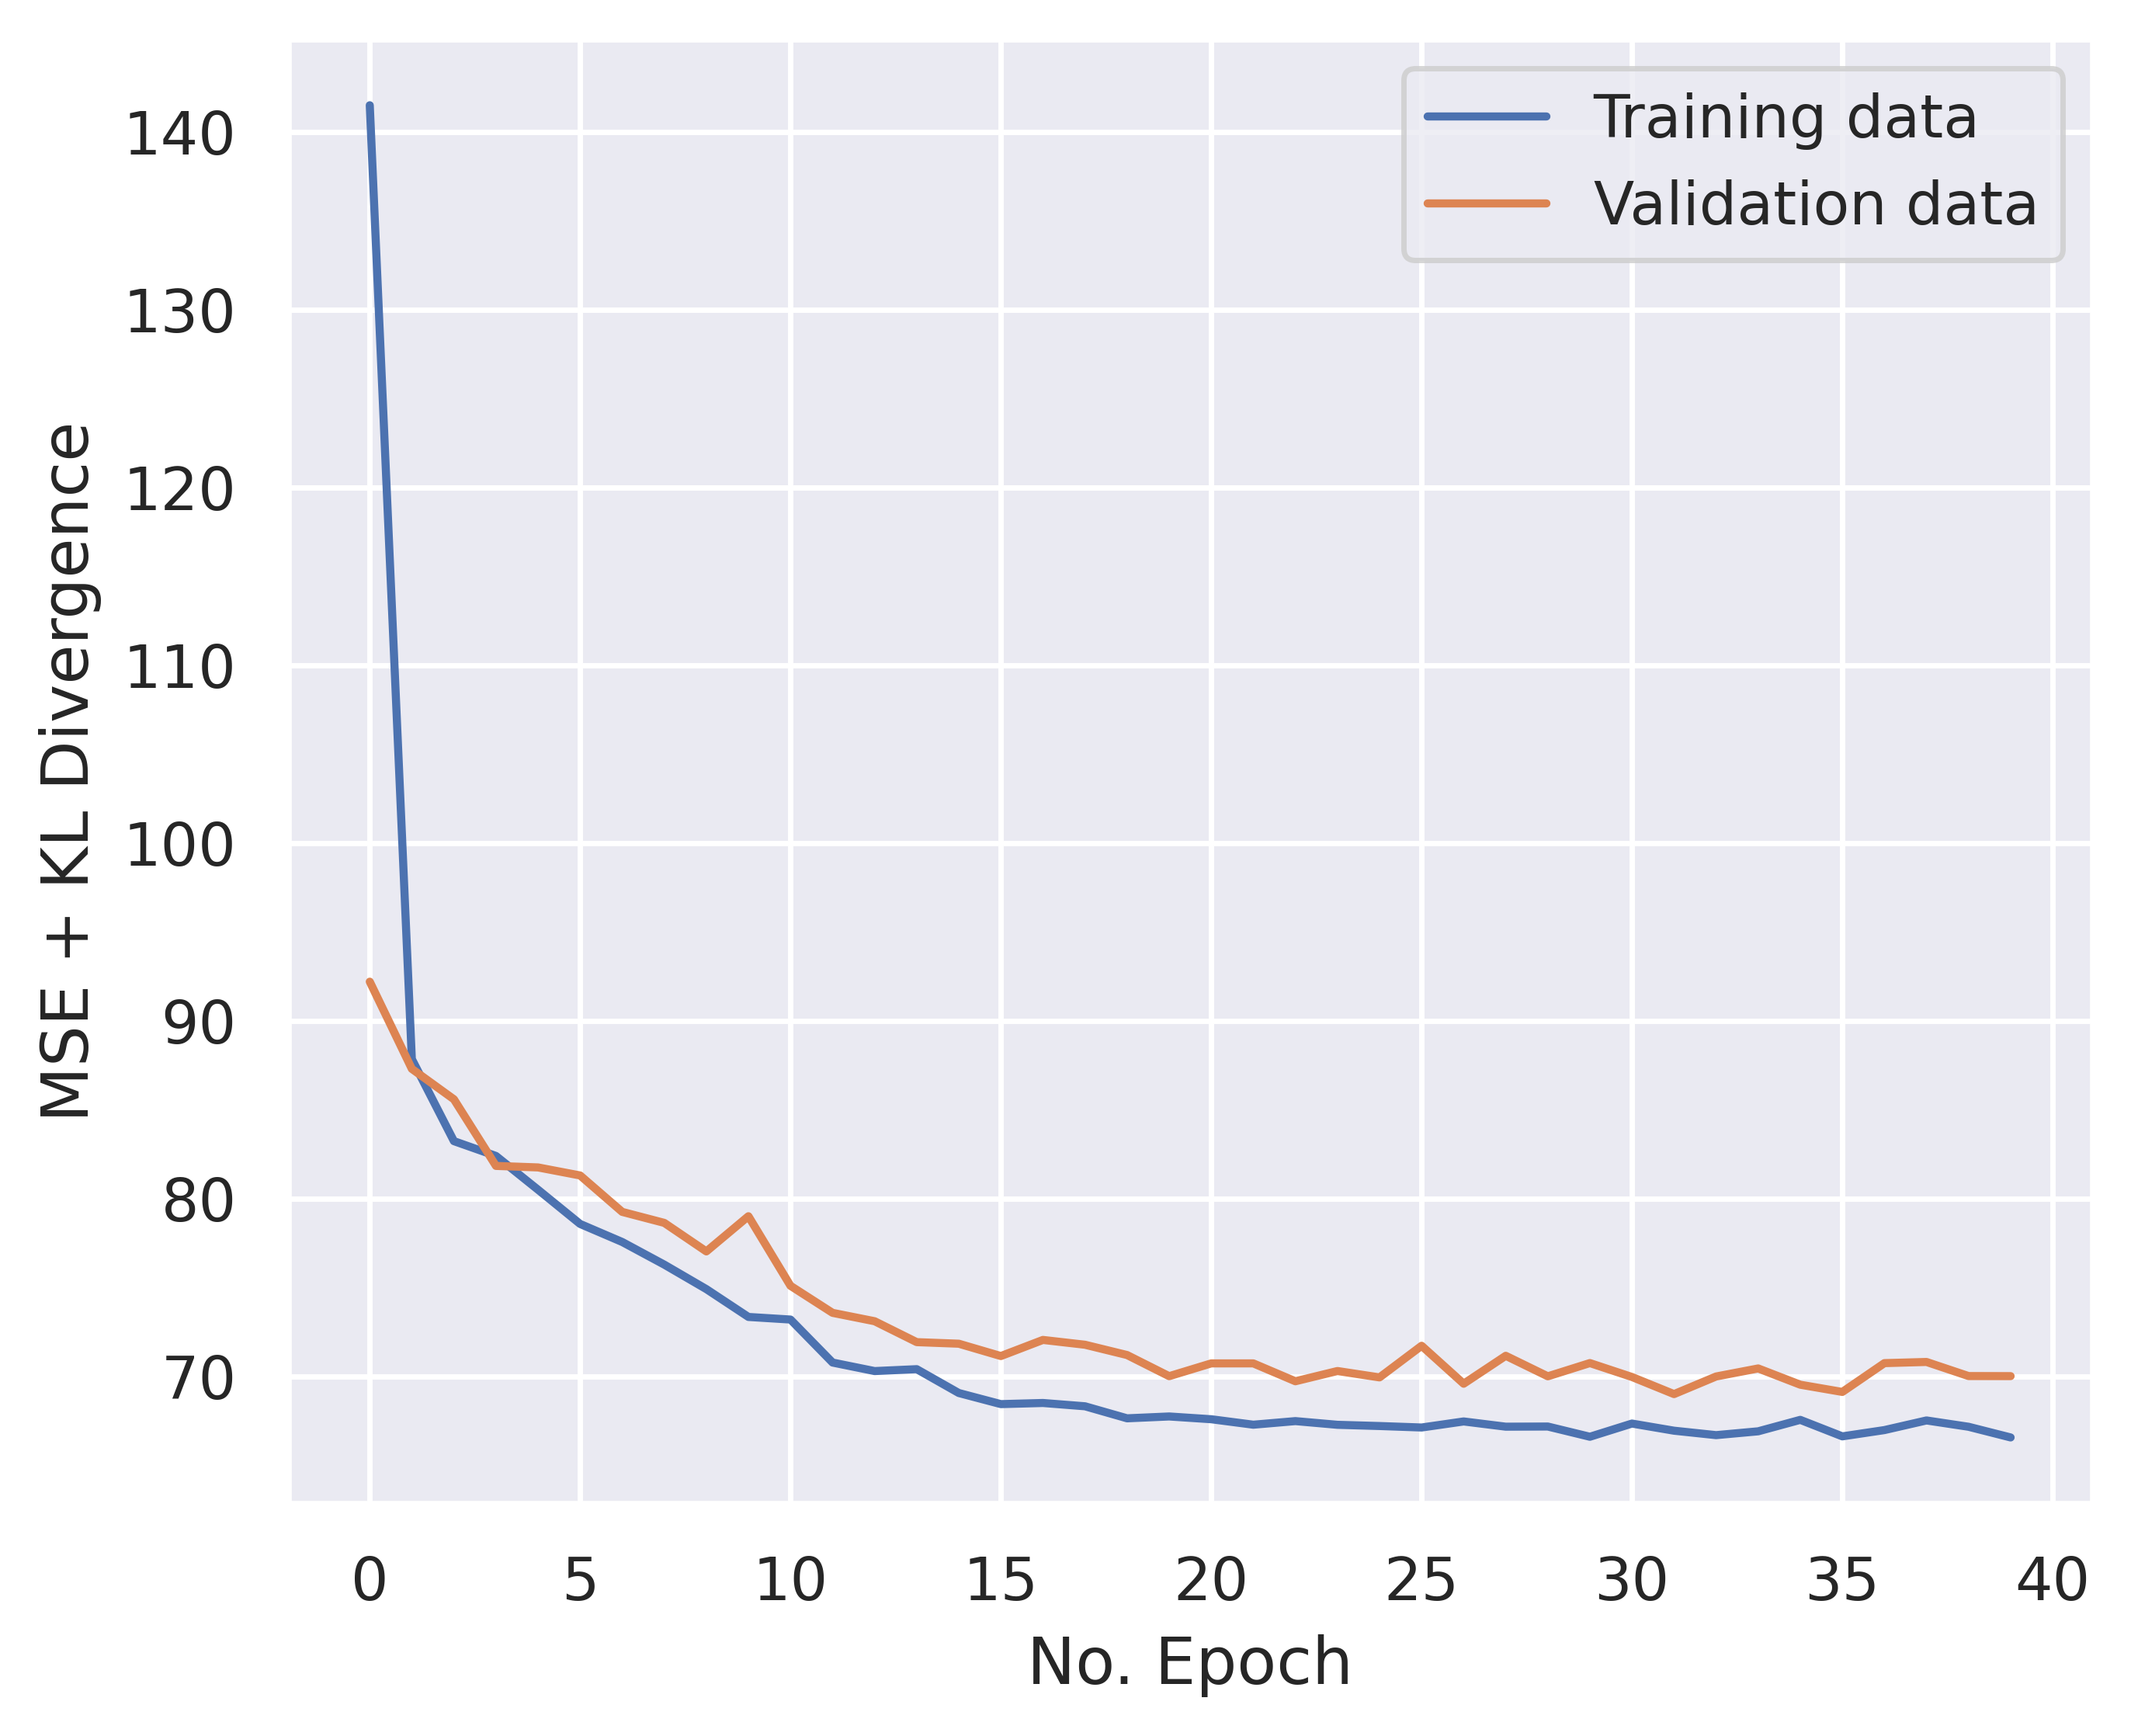

In [13]:
# plot and save the figure
save_path = pathlib.Path('../1.data-exploration/figures/training_curve.png')

plt.figure(figsize=(6, 5), dpi = 500)
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("No. Epoch")
plt.legend()
plt.savefig(save_path)
plt.show()

In [14]:
cp_vae.vae
cp_vae.vae.evaluate(subset_test_df)

5/5 [==============================] - 0s 3ms/step - loss: 70.0279 - recon: 63.6160 - kl: 6.4119


[70.02794647216797, 63.61601257324219, 6.41192626953125]

In [15]:
encoder = cp_vae.encoder_block["encoder"]
decoder = cp_vae.decoder_block["decoder"]

In [16]:
data_dir = "../0.data-download/data/"
datafs = load_data(data_dir, adult_or_pediatric = "all")
dependency_df = datafs[1]
sample_df = datafs[0]

/home/markw/gene_dependency_representations/2.train-VAE/.././0.data-download/scripts/data_loader.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  dependency_df = pd.read_csv(dependency_data_file, index_col=0).reset_index().dropna(1)


In [17]:
train_init['train_or_test'] = train_init.apply(lambda _: 'train', axis=1)
test_init['train_or_test'] = test_init.apply(lambda _: 'test', axis=1)

In [18]:
# create a data frame of both test and train gene dependency data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["age_category", "sex"]] = train_and_test.age_and_sex.str.split(pat='_',expand=True)
train_and_test_subbed = train_and_test.filter(gene_list, axis = 1)
asdf = []
asdf = pd.DataFrame(asdf)
metadata = asdf.assign(
    DepMap_ID = train_and_test.DepMap_ID.astype(str), 
    age_category = train_and_test.age_category.astype(str), 
    sex = train_and_test.sex.astype(str), 
    train_or_test = train_and_test.train_or_test.astype(str)
    )
metadata

,DepMap_ID,age_category,sex,train_or_test
0,ACH-000580,Adult,Male,train
1,ACH-000247,Adult,Female,train
2,ACH-000873,Adult,Male,train
3,ACH-001041,Adult,Female,train
4,ACH-000202,Adult,Female,train
...,...,...,...,...
879,ACH-000682,Adult,Male,test
880,ACH-001145,Adult,Female,test
881,ACH-001652,Adult,Female,test
882,ACH-000946,Adult,Female,test


In [19]:
latent_complete = np.array(encoder.predict(train_and_test_subbed)[2])
latent_df = pd.DataFrame(latent_complete)

28/28 [==============================] - 0s 1ms/step


In [20]:
age_category = metadata.pop("age_category")
sex = metadata.pop("sex")
train_test = metadata.pop("train_or_test")

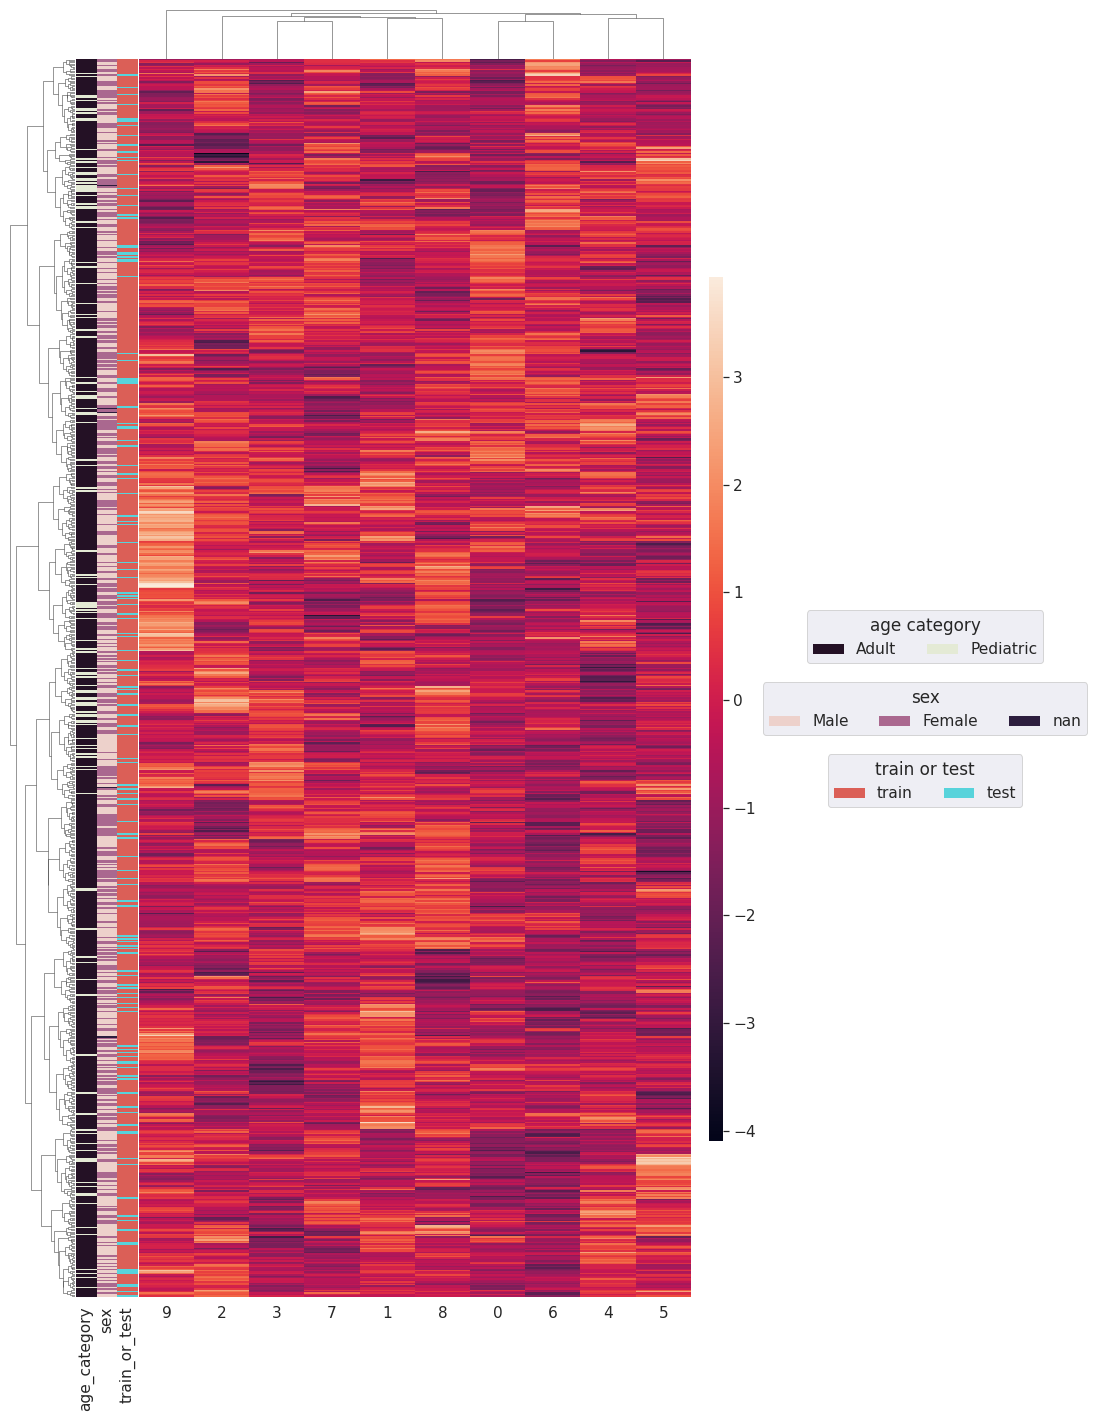

In [21]:

# display clustered heatmap of coefficients
lut_pal = sns.cubehelix_palette(age_category.unique().size, light=.9, dark=.1, reverse=True, start=1, rot=-2)
put_pal = sns.cubehelix_palette(sex.unique().size)
mut_pal = sns.color_palette("hls", train_test.unique().size)

lut = dict(zip(age_category.unique(), lut_pal))
put = dict(zip(sex.unique(), put_pal))
mut = dict(zip(train_test.unique(), mut_pal))

row_colors1 = age_category.map(lut)
row_colors2 = sex.map(put)
row_colors3 = train_test.map(mut)

network_node_colors = pd.DataFrame(row_colors1).join(pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3)))

sns.set(font_scale=1.4)
g = sns.clustermap(latent_df, method='ward', figsize=(10, 20), row_colors= network_node_colors, yticklabels=False, dendrogram_ratio=(.1,.04), cbar_pos=(1,.2, 0.02, .6))


xx = []
for label in age_category.unique():
    x = g.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
    xx.append(x)
# add the legend
legend3 = plt.legend(xx, age_category.unique(), loc="center", title='age category', ncol=2, bbox_to_anchor=(1.3, .55), bbox_transform=gcf().transFigure)


yy = []
for label in sex.unique():
    y = g.ax_row_dendrogram.bar(0, 0, color=put[label], label=label, linewidth=0)
    yy.append(y)  
# add the second legend
legend4 = plt.legend(yy, sex.unique(), loc="center", title='sex', ncol=3, bbox_to_anchor=(1.3, .5), bbox_transform=gcf().transFigure)
plt.gca().add_artist(legend3)


zz = []
for label in train_test.unique():
    z = g.ax_row_dendrogram.bar(0, 0, color=mut[label], label=label, linewidth=0)
    zz.append(z)
# add the third legend
legend5 = plt.legend(zz, train_test.unique(), loc="center", title='train or test', ncol=2, bbox_to_anchor=(1.3, .45), bbox_transform=gcf().transFigure)
plt.gca().add_artist(legend4)


# save the figure
heat_save_path = pathlib.Path('../1.data-exploration/figures/heatmap.png')
g.figure.savefig(heat_save_path, dpi=600)
